# Advanced Lane Finding Project

The tasks to accomplish in this project are as following:

 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
 2. Apply a distortion correction to raw images.
 3. Use color transforms, gradients, etc., to create a thresholded binary image.
 4. Apply a perspective transform to rectify binary image ("birds-eye view").
 5. Detect lane pixels and fit to find the lane boundary.
 6. Determine the curvature of the lane and vehicle position with respect to center.
 7. Warp the detected lane boundaries back onto the original image.
 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
# Import necessary packages
import os
import numpy as np
import glob # to read files from dir
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

os.getcwd()

'C:\\Jandal\\workspace_P\\UNDSC\\CarND-Advanced-Lane-Lines'

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
The solution can be found in <font color=blue>1_Camera_Calibration.ipynb</font> notebook in this directory.

### 2 - 4 steps 
The solution can be found in <font color=blue>Stage1_Pipeline_a.ipynb</font> notebook in this directory.

### 5 - 8 steps 
The solution can be found in <font color=blue>Stage1_Pipeline_b.ipynb</font> notebook in this directory.

### This notebook has end to end pipeline executed on test images and sample video

In [2]:
# Reading camera calibration variables from pickle object
path_dir = os.getcwd()+"\\pickled_data\\"
pickle_obj = pickle.load(open(path_dir+"camera_calibration.p", "rb" ))
mtx = pickle_obj["mtx"]
dist = pickle_obj["dist"]

#### All helper functions required for pipeline can be found in <font color=blue>pipeline_helper_functions.py</font>

In [156]:
# Getting helper functions
%run pipeline_helper_functions.py

<Figure size 432x288 with 0 Axes>

### Defining Image Pipeline

In [148]:
# Defining pipeline function for image using helper functions
from random import randint
import datetime
import time
def image_pipeline(original_image):
    #1. Undistort, blur and gray
    undist_img = undistorted_img(originalImage, mtx, dist)
    blur_img = cv2.GaussianBlur(undist_img, (9, 9), 0)
    gray_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2GRAY)
    print("gray_img.shape = ", gray_img.shape)

    #2. Apply combines thresholding
    gray_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
    combined_thr_img = pipeline_color_thresholding(gray_img, s_thresh=(100,255), sx_thresh=(10,150))
    print("combined_thr_img.shape = ", combined_thr_img.shape)

    #3. Get warp perspective of undistorted image
    # Calculate the source points
    src = np.float32([[300, 650], [1000, 650], [800, 520], [500, 520]])
    # Calculate the destination points
    img_h = gray_img.shape[0] #height = [0, 720]
    img_w = gray_img.shape[1] #width = [0, 1280]
    offset = 50 # Setting offset value to get dst values accordingly
    dst = np.float32([[offset, offset],             # top left
                      [img_h-offset, offset],       # bottom left
                      [img_h-offset, img_w-offset], # bottom right
                      [offset, img_w-offset]])      # top right
    warped_img = WarpPerspective(gray_img, src, dst) # get perspective transformation
    print("warped_img.shape = ", warped_img.shape)
    
    #4. Get sliding windows
    #leftx, lefty, rightx, righty, out_img =  get_sliding_windows(warped_img)
    #sw_visual = visualize_sliding_windows(warped_img, leftx, lefty, rightx, righty, out_img)
    
    #4. Get smooth lane pixels, alternative to sliding windows method
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    margin = 100 # hyper-param
    ll_inds, rl_inds, nonzerox, nonzeroy, left_fitx, right_fitx, ploty = get_smooth_lanePixels(warped_img,\
                                                                                     margin, left_fit, right_fit)
    #sm_visual = visualize_smooth_lanePixels(combined_thr_img, margin, ll_inds, rl_inds, \
    #                                       nonzerox, nonzeroy, left_fitx, right_fitx, ploty)
    
    #5. Unwarp to original image
    result_img = unwarp_image(warped_img, original_image, src, dst, left_fit, right_fit)
    
    #6. Print radius of curvature
    radius, distance = get_RealRadiusOfCurvature(combined_thr_img, left_fit, right_fit)
    cv2.putText(result_img,"Radius of Curvature is " + str(int(radius))+ "m", (100,100), 2, 1, (255,255,0),2)
    cv2.putText(result_img,"Distance from center is {:2f}".format(distance)+ "m", (100,150), 2, 1, (255,255,0),2)
    
    #7. Returning the image
    #new_img = np.dstack((combined_thr_img*255,combined_thr_img*255,combined_thr_img*255))
    #result_img[100:240,1000:1200, :] = cv2.resize(new_img, (200,140))
    result_img = result_img.astype(np.uint8)
    
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y%m%d %H%M%S')
    
    #return cv2.cvtColor(result_img, cv2.COLOR_RGB2GRAY)
    return result_img

### Running Image Pipeline on Test Images

gray_img.shape =  (720, 1280)
combined_thr_img.shape =  (720, 1280, 3)
warped_img.shape =  (1280, 720, 3)


error: OpenCV(3.4.1) C:\Miniconda3\conda-bld\opencv-suite_1533128839831\work\modules\core\src\array.cpp:3232: error: (-215) cn <= 4 in function cv::scalarToRawData


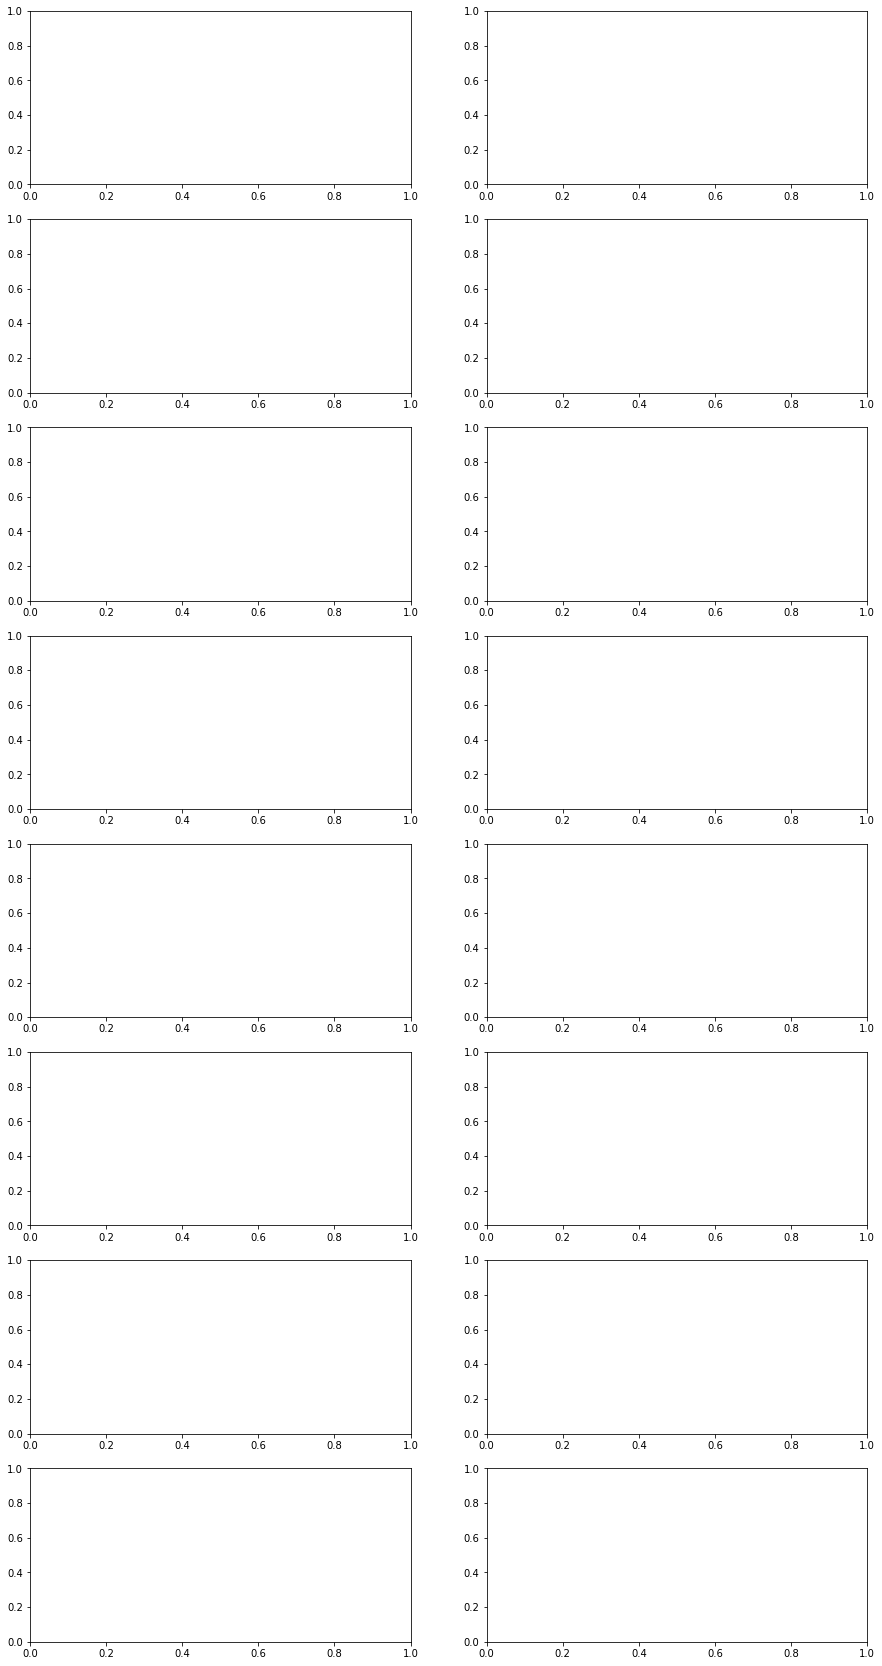

In [149]:
# Testing on test images
f, axes= plt.subplots(8,2,figsize=(15,30))

path_dir = os.getcwd()+"\\test_images\\"
images = glob.glob(path_dir+'/*.jpg') # Reading Images from test_images folder

for index, image in enumerate(images):
    img_input = cv2.imread(image)
    originalImage = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)
    finalImage = image_pipeline(originalImage)
    #cv2.imwrite('output_images/'+str(index)+'.jpg', cv2.cvtColor(finalImage,cv2.COLOR_BGR2RGB))
    axes[index,0].imshow(originalImage)
    axes[index,1].imshow(cv2.cvtColor(finalImage,cv2.COLOR_BGR2RGB))

gray_img.shape =  (720, 1280)
combined_thr_img.shape =  (720, 1280, 3)
warped_img.shape =  (720, 1280, 3)


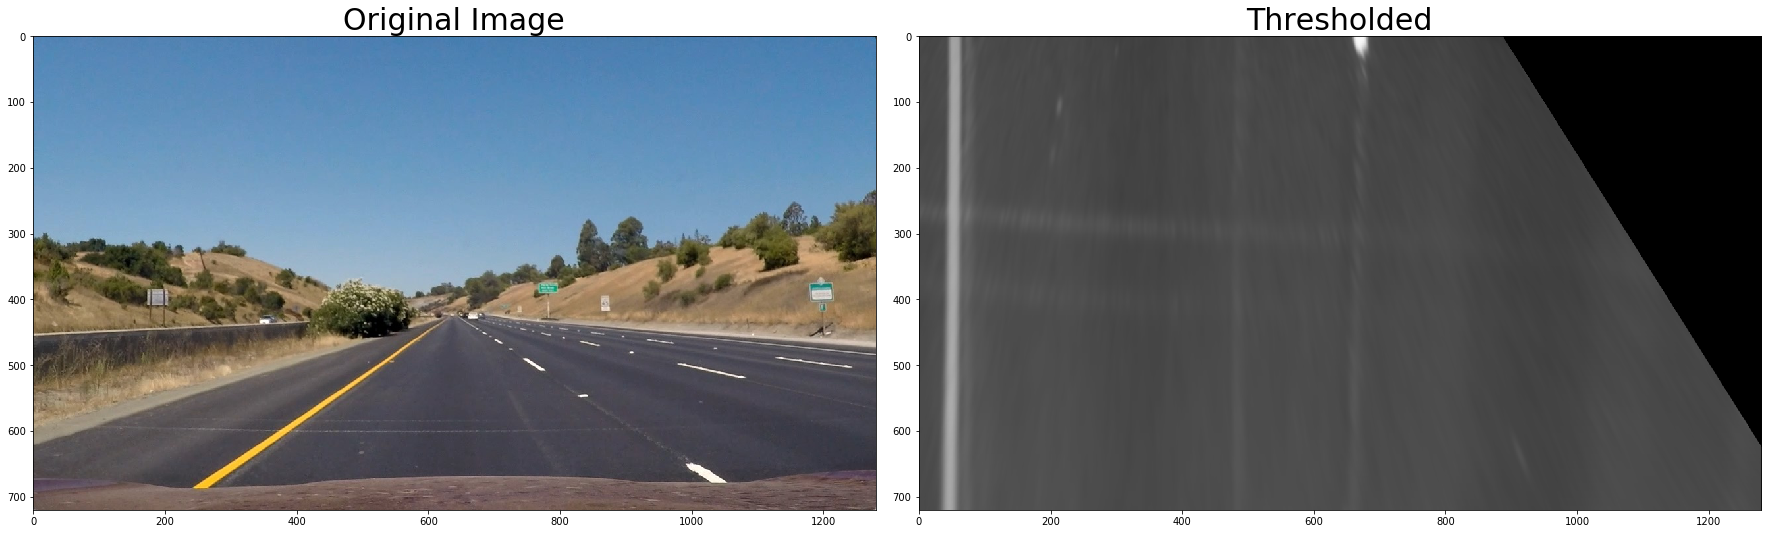

In [158]:
# Testing on test images
path_dir = os.getcwd()+"\\test_images\\"
images = glob.glob(path_dir+'/*.jpg') # Reading Images from test_images folder

img_input = cv2.imread(images[0]) 
originalImage = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)

#1. Undistort, blur and gray
undist_img = undistorted_img(originalImage, mtx, dist)
blur_img = cv2.GaussianBlur(undist_img, (9, 9), 0)
gray_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2GRAY)
print("gray_img.shape = ", gray_img.shape)

#2. Apply combines thresholding
gray_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
combined_thr_img = pipeline_color_thresholding(gray_img, s_thresh=(100,255), sx_thresh=(10,150))
print("combined_thr_img.shape = ", combined_thr_img.shape)

#3. Get warp perspective of undistorted image
# Calculate the source points
src = np.float32([[300, 650], [1000, 650], [800, 520], [500, 520]])
# Calculate the destination points
img_h = gray_img.shape[0] #height = [0, 720]
img_w = gray_img.shape[1] #width = [0, 1280]
offset = 50 # Setting offset value to get dst values accordingly
dst = np.float32([[offset, offset],             # top left
                  [img_h-offset, offset],       # bottom left
                  [img_h-offset, img_w-offset], # bottom right
                  [offset, img_w-offset]])      # top right
warped_img = WarpPerspective(gray_img, src, dst) # get perspective transformation
print("warped_img.shape = ", warped_img.shape)

plot_the_result(originalImage, warped_img) 

In [159]:
#4. Get sliding windows
leftx, lefty, rightx, righty, out_img =  get_sliding_windows(warped_img)

#sw_visual = visualize_sliding_windows(combined_thr_img, leftx, lefty, rightx, righty, out_img)

plot_the_result(originalImage, warped_img) 

error: OpenCV(3.4.1) C:\Miniconda3\conda-bld\opencv-suite_1533128839831\work\modules\core\src\array.cpp:3232: error: (-215) cn <= 4 in function cv::scalarToRawData


In [ ]:
#4. Get smooth lane pixels, alternative to sliding windows method
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
margin = 100 # hyper-param
ll_inds, rl_inds, nonzerox, nonzeroy, left_fitx, right_fitx, ploty = get_smooth_lanePixels(combined_thr_img,\
                                                                                 margin, left_fit, right_fit)
#sm_visual = visualize_smooth_lanePixels(combined_thr_img, margin, ll_inds, rl_inds, \
#                                       nonzerox, nonzeroy, left_fitx, right_fitx, ploty)

In [ ]:
#5. Unwarp to original image
result_img = unwarp_image(combined_thr_img, original_image, src, dst, left_fit, right_fit)

#6. Print radius of curvature
radius, distance = get_RealRadiusOfCurvature(combined_thr_img, left_fit, right_fit)
cv2.putText(result_img,"Radius of Curvature is " + str(int(radius))+ "m", (100,100), 2, 1, (255,255,0),2)
cv2.putText(result_img,"Distance from center is {:2f}".format(distance)+ "m", (100,150), 2, 1, (255,255,0),2)  